In [2]:
# 
root = "/home/shi/WorkSpace/projects/scMultiNet_Data/"

code_loc = "/Users/shipan/Documents/workspace_EMT_LM/scMultiNet_workspace/"

save_folder = root + "/Step_4_data/"

cls_nb = 4

force_normalise = True

save_loc = "/home/shi/WorkSpace/projects/scMultiNet_Data/Step_4_data/"

In [3]:
import pandas as pd

# Load the CSV file 
file_path = root + "/Step_4_data/source/McFaline_emt_dataset_obs_signature_scores.csv"
data = pd.read_csv(file_path)

# Display the first few rows of the dataframe to understand its structure
data.head()


,Unnamed: 0,samples,pseudotimes,batch,stimulus,Ground_truth,CellLine,Experiment,Tissue,epithelial_score,mesenchymal_score,pEMT_score
0,AAACATACGAATAG.1_Mock_TGFB_agregated_samples,AAACATACGAATAG.1_Mock_TGFB_agregated_samples,61.045475,4,MOCK,Mock_inner,MCF10A,McFaline,Breast,0.027040,0.714605,0.263295
1,AAACATACGCTAAC.1_Mock_TGFB_agregated_samples,AAACATACGCTAAC.1_Mock_TGFB_agregated_samples,20.693702,4,MOCK,Mock_inner,MCF10A,McFaline,Breast,0.011440,-0.359363,-1.236127
2,AAACATACGGACAG.1_Mock_TGFB_agregated_samples,AAACATACGGACAG.1_Mock_TGFB_agregated_samples,45.184751,4,MOCK,Mock_inner,MCF10A,McFaline,Breast,-0.035682,-0.217827,-2.148555
3,AAACATTGTCTCAT.1_Mock_TGFB_agregated_samples,AAACATTGTCTCAT.1_Mock_TGFB_agregated_samples,55.529960,4,MOCK,Mock_inner,MCF10A,McFaline,Breast,1.621553,0.293021,-1.673410
4,AAACCGTGTCACGA.1_Mock_TGFB_agregated_samples,AAACCGTGTCACGA.1_Mock_TGFB_agregated_samples,57.685620,4,MOCK,Mock_inner,MCF10A,McFaline,Breast,0.055191,0.165526,-0.083815


In [4]:
if force_normalise:
    # normalise epithelial_score, mesenchymal_score, and pEMT_score to 0-1
    data["epithelial_score"] = (data["epithelial_score"] - data["epithelial_score"].min()) / (data["epithelial_score"].max() - data["epithelial_score"].min())
    data["mesenchymal_score"] = (data["mesenchymal_score"] - data["mesenchymal_score"].min()) / (data["mesenchymal_score"].max() - data["mesenchymal_score"].min())
    data["pEMT_score"] = (data["pEMT_score"] - data["pEMT_score"].min()) / (data["pEMT_score"].max() - data["pEMT_score"].min())

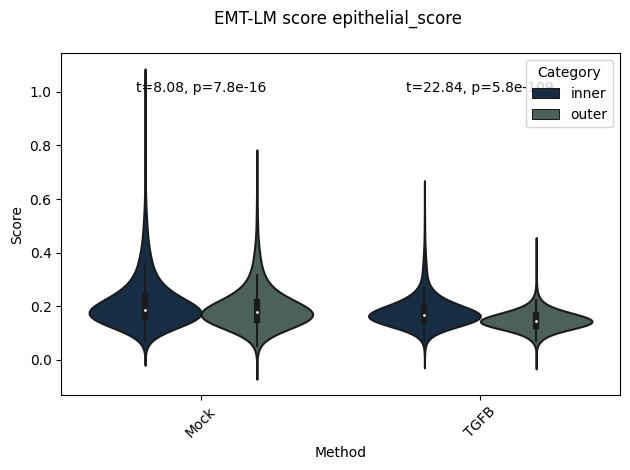

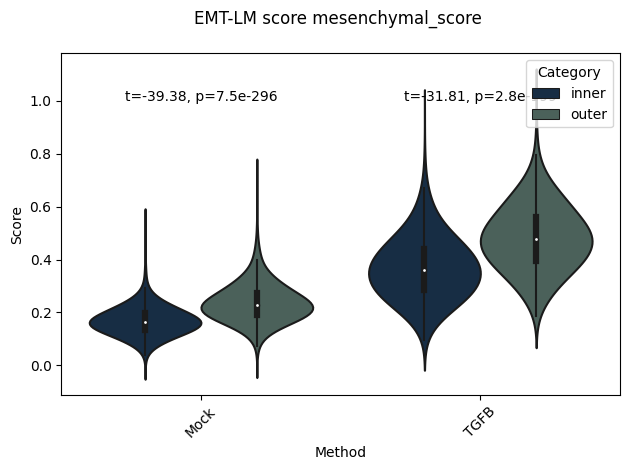

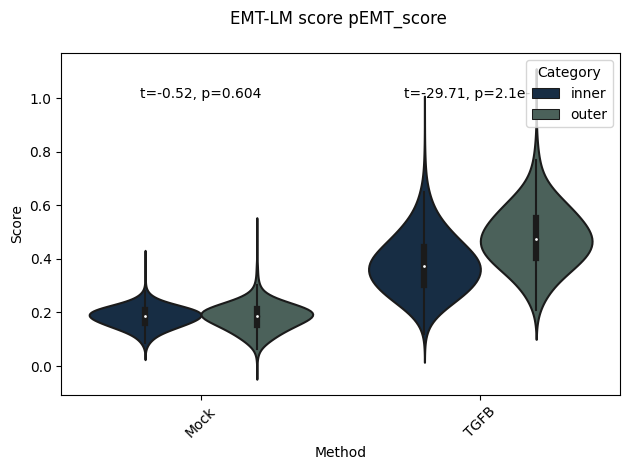

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats

def generate_violin_plot(data,score_name, save_folder):
    # 定义扩展后的颜色列表（十六进制格式）
    hex_colors = ["#102d4b", "#47655b", "#89bcb8", "#fce5cd"]

    # 将GT_str列的值拆分为方法和类别两列
    data[['Method', 'Category']] = data['Ground_truth'].str.split('_', expand=True)

    # 绘制小提琴图，并使用定义的颜色
    sns.violinplot(x='Method', y='Score', hue='Category', data=data, palette=hex_colors,
                   bw=0.5, scale='width', inner="box", order=sorted(data['Method'].unique()))

    # 对每个方法下的两个类别进行T检验，并将结果显示在图中
    for method in data['Method'].unique():
        cat1_scores = data[(data['Method'] == method) & (data['Category'] == data['Category'].unique()[0])]['Score']
        cat2_scores = data[(data['Method'] == method) & (data['Category'] == data['Category'].unique()[1])]['Score']
        t_stat, p_val = stats.ttest_ind(cat1_scores, cat2_scores)

        # 根据p值的大小选择合适的显示格式
        if (p_val < 0.001):
            p_str = f"p={p_val:.1e}"  # 使用科学计数法显示非常小的p值
        else:
            p_str = f"p={p_val:.3f}"  # 使用小数显示较大的p值

        plt.text(x=sorted(data['Method'].unique()).index(method), y=data['Score'].max(),
                 s=f"t={t_stat:.2f}, {p_str}", fontsize=10, ha='center')

    # 设置图例
    plt.legend(title='Category')

    # 设置x轴标签
    plt.xticks(range(len(data['Method'].unique())), sorted(data['Method'].unique()), rotation=45)

    # 显示图表
    plt.title(f'EMT-LM score {score_name} \n ')
    plt.xlabel('Method')
    plt.ylabel('Score')
    plt.tight_layout()
    plt.savefig(save_folder + f"/Mcf_violin_{score_name}.pdf")
    plt.show()

for score_method in ["epithelial_score", "mesenchymal_score", "pEMT_score"]:
    # 将label和score整理到一个DataFrame中
    df = pd.DataFrame({
        'Ground_truth': data["Ground_truth"],  # 将str-> dataFrame
        'Score': data[score_method]   # 
    })
    generate_violin_plot(df, score_method, save_folder)


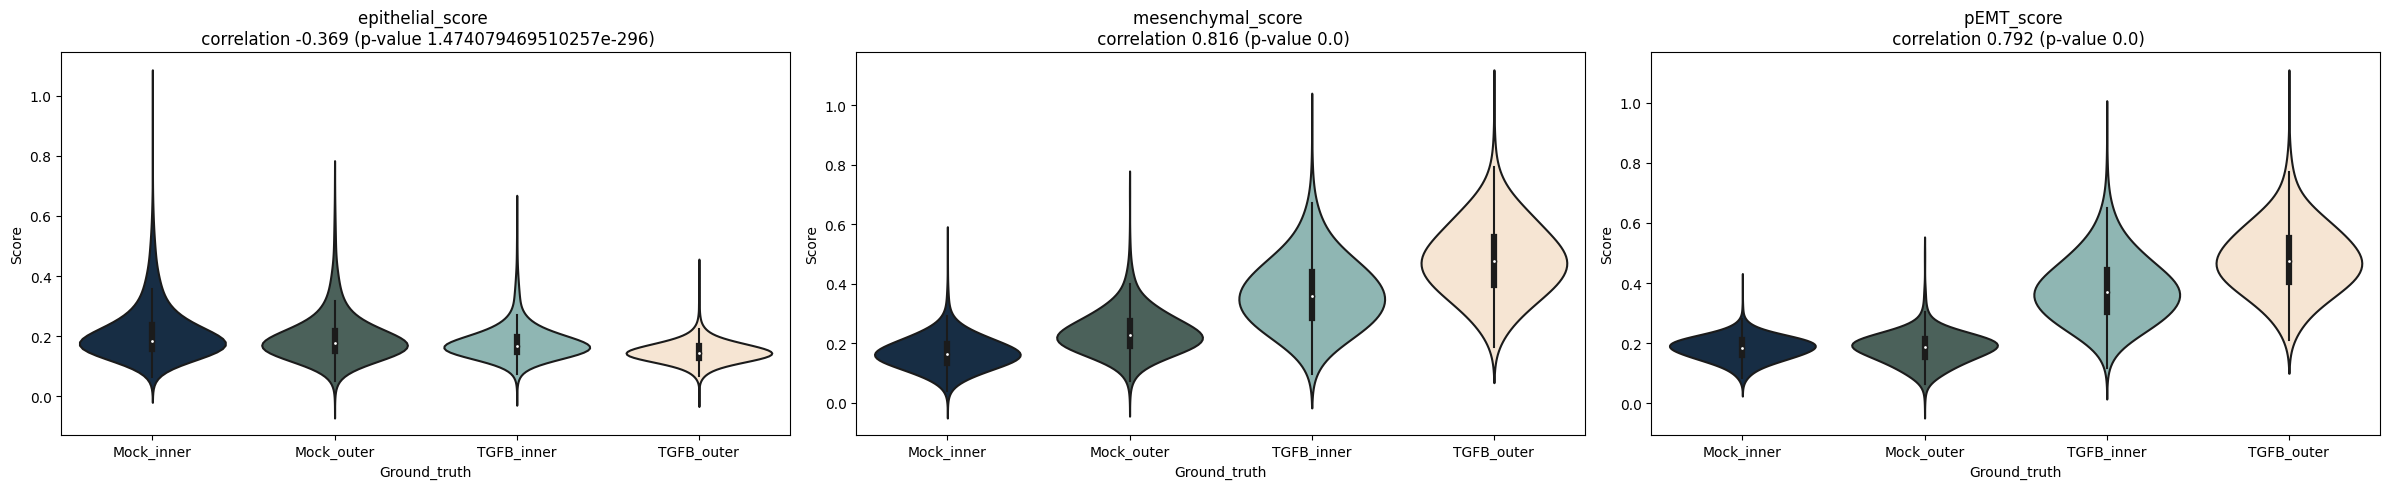

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

subgfig_nb = 3

# Map Ground_truth to numeric values
ground_truth_mapping = {gt: i for i, gt in enumerate(sorted(data['Ground_truth'].unique()))}
data['Ground_truth_numeric'] = data['Ground_truth'].map(ground_truth_mapping)


# Define targets
targets = ['epithelial_score', 'mesenchymal_score', 'pEMT_score']


hex_colors =  ["#102d4b","#47655b","#89bcb8","#fce5cd","#fff2cc","#f4cccc","#ea9999","#e06666"]
color_palette = sns.color_palette(hex_colors)  # 将十六进制颜色转换为Seaborn可用的颜色格式

# Initialize figure and axes for 3 subplots
fig, axes = plt.subplots(1, subgfig_nb, figsize=(8*subgfig_nb, 5))#, sharey=True)
#fig.subplots_adjust(hspace=0.8, wspace=0.2)

# Store correlation and p-value information
correlation_info = {}

# Create violin plots
for i, target in enumerate(targets):
    sns.violinplot(ax=axes[i], x='Ground_truth', y=target, data=data,palette=hex_colors,
                   bw=0.5,scale='width',
                   inner="box", order=sorted(data['Ground_truth'].unique()))
    
    correlation, p_value = stats.spearmanr(data['Ground_truth_numeric'], data[target])
    axes[i].set_title(f"{target} \n correlation {correlation:0.3f} (p-value {p_value})")
    axes[i].set_xlabel('Ground_truth')
    axes[i].set_ylabel('Score')


# Adjust layout
plt.tight_layout()

plt.savefig(save_loc+"/other_idx_mcf.pdf")
# Show plot
plt.show()


#######################



/var/folders/y2/l_8q7qw56_x9sqpbx0__tbg80000gn/T/ipykernel_23618/846892630.py:28: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(ax=axes[i], x='Ground_truth', y=target, data=data, palette=hex_colors,order=sorted(data['Ground_truth'].unique()),jitter=True)
/var/folders/y2/l_8q7qw56_x9sqpbx0__tbg80000gn/T/ipykernel_23618/846892630.py:28: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(ax=axes[i], x='Ground_truth', y=target, data=data, palette=hex_colors,order=sorted(data['Ground_truth'].unique()),jitter=True)
/var/folders/y2/l_8q7qw56_x9sqpbx0__tbg80000gn/T/ipykernel_23618/846892630.py:28: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(ax=axes[i], x='Ground_truth', y=target, data=data, palette=hex_colors,order=sorted(data['Ground_truth'].unique()),jitter=True)


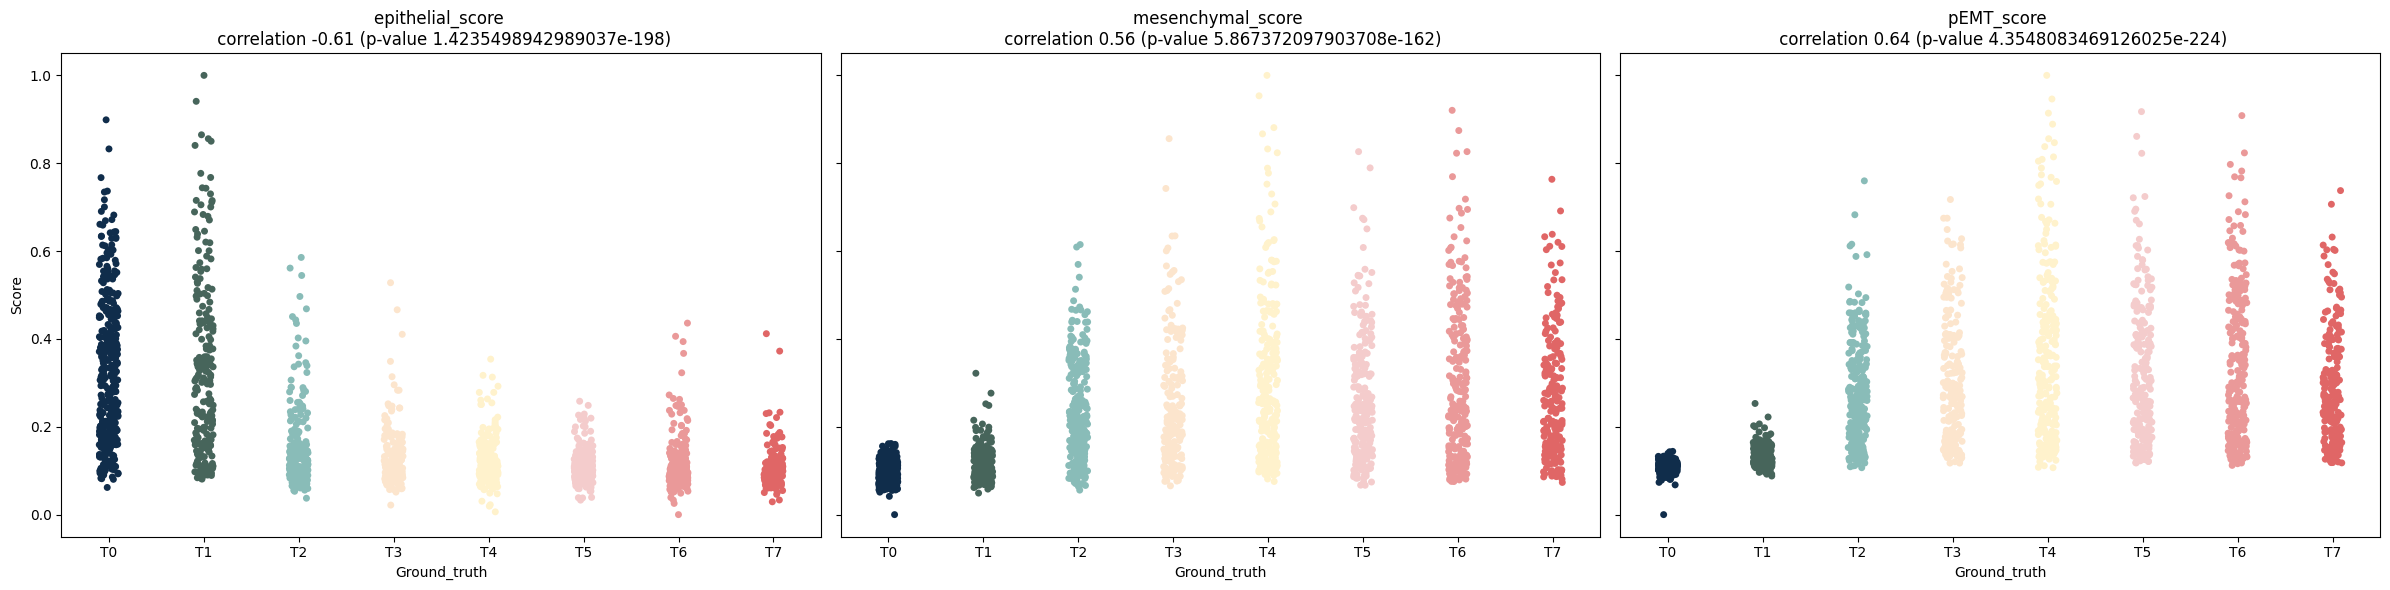

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

subgfig_nb = 3

# Map Ground_truth to numeric values
ground_truth_mapping = {gt: i for i, gt in enumerate(sorted(data['Ground_truth'].unique()))}
data['Ground_truth_numeric'] = data['Ground_truth'].map(ground_truth_mapping)

# Define targets
targets = ['epithelial_score', 'mesenchymal_score', 'pEMT_score']


hex_colors =  ["#102d4b","#47655b","#89bcb8","#fce5cd","#fff2cc","#f4cccc","#ea9999","#e06666"]
color_palette = sns.color_palette(hex_colors)  # 将十六进制颜色转换为Seaborn可用的颜色格式

# Initialize figure and axes for 3 subplots
fig, axes = plt.subplots(1, subgfig_nb, figsize=(8*subgfig_nb, 6), sharey=True)
#fig.subplots_adjust(hspace=0.8, wspace=0.2)

# Store correlation and p-value information
correlation_info = {}

# Create violin plots
for i, target in enumerate(targets):
    # 绘制点图，并使用定义的颜色
    sns.stripplot(ax=axes[i], x='Ground_truth', y=target, data=data, palette=hex_colors,order=sorted(data['Ground_truth'].unique()),jitter=True)
    correlation, p_value = stats.spearmanr(data['Ground_truth_numeric'], data[target])
    axes[i].set_title(f"{target} \n correlation {correlation:0.2f} (p-value {p_value})")
    axes[i].set_xlabel('Ground_truth')
    axes[i].set_ylabel('Score')


# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


